##### Ce notebook met en œuvre la méthode Grad-ECLIP appliquée à un modèle ViT dans CLIP

#### Objectif

Le but de ce notebook est d’accéder directement à l’architecture interne du modèle ViT utilisé dans CLIP, afin d’**adapter fidèlement la méthode d’explicabilité Grad-ECLIP** à ce type de transformeur visuel.

Concrètement, il s’agit de ;
- récupérer les embeddings des patchs visuels,
- extraire le vecteur le token CLS qui encode l’image entière,
- obtenir les vecteurs d’attention (queries, keys, values),
- calculer les gradients associés au score CLIP.

Ces éléments permettent de produire une carte de chaleur visuelle montrant l’importance de chaque patch de l’image, selon la formule Grad-ECLIP :


$$
H_i = \text{ReLU} \left( \sum_c w_c \cdot \lambda_i \cdot v_{ic} \right)
$$


Cette visualisation met en évidence les zones de l’image qui ont le plus influencé la similarité avec un texte donné

## 1. Chargement du modèle CLIP et préparation des données 

Cette cellule charge le modèle **ViT (Vision Transformer)** pré-entraîné pour la classification d'images ainsi que le processeur d'image associé. Elle prépare aussi une fonction de prétraitement qui conserve les proportions de l'image tout en s'assurant que ses dimensions soient compatibles avec les patchs de ViT (taille multiple de 16×16).

 Détails des opérations :
- `AutoImageProcessor` : permet de charger automatiquement les paramètres de normalisation associés au modèle ViT.
- `ViTForImageClassification` : charge le modèle ViT-B/16 pré-entraîné sur ImageNet.
- `_transform` applique la normalisation avec les moyennes et écarts-types appris.

Fonction `imgprocess_keepsize(img)` :
Elle applique les étapes suivantes à une image d'entrée :

 1. **Calcul des nouvelles dimensions** compatibles avec la taille des patchs (ex. 16×16), pour que chaque patch soit complet :  
   $$
   n_w = \left\lceil \frac{w \times \text{scale}}{p_w} \right\rceil \cdot p_w, \quad
   n_h = \left\lceil \frac{h \times \text{scale}}{p_h} \right\rceil \cdot p_h
   $$

 2. **Redimensionnement de l’image** via interpolation bicubique pour atteindre les dimensions $(n_h, n_w)$.

 3. **Conversion RGB + Normalisation** (centrage, réduction d’échelle) adaptée au modèle ViT.

Cette fonction est essentielle pour garantir que l’image soit bien découpée en patchs exploitables par le transformeur visuel.


In [2]:
from transformers import AutoImageProcessor, ViTForImageClassification
import torch
import math
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
from torchvision.transforms.functional import InterpolationMode
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
%matplotlib inline
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")

model.to(device)

_transform = Compose([
        ToTensor(),
        Normalize(image_processor.image_mean, image_processor.image_std),
    ])

def imgprocess_keepsize(img, patch_size=[16, 16], scale_factor=1):
    w, h = img.size
    ph, pw = patch_size
    nw = int(w * scale_factor / pw + 0.5) * pw
    nh = int(h * scale_factor / ph + 0.5) * ph

    ResizeOp = Resize((nh, nw), interpolation=InterpolationMode.BICUBIC)
    img = ResizeOp(img).convert("RGB")
    return _transform(img)

## 2. Mécanisme d'attention dans ViT et encodage dense

La fonction `forward_attention` reproduit fidèlement le calcul d’attention dans une couche de ViT. Ce mécanisme est crucial pour accéder directement aux poids d’attention ainsi qu’aux matrices \( Q \), \( K \), \( V \) nécessaires au calcul d’explicabilité Grad-ECLIP.

1. **Fonctionnement de l’attention multi-têtes :**

Le cœur de l’attention suit la formule :

$$
\text{Attention}(Q,K,V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

avec :
- \( Q \) (query) : vecteurs de requêtes générés à partir de l’entrée
- \( K \) (key) : vecteurs d’indexation des patchs
- \( V \) (value) : vecteurs contenant l’information réelle
- (d_k) : dimension des clés (normalisation)

### Implémentation `forward_attention` :

- On extrait les matrices \( Q, K, V \) à partir des poids internes du modèle.
- Le produit scalaire \( QK^T \) est calculé, normalisé, puis passé dans un softmax pour obtenir les **poids d’attention**.
- Ces poids sont ensuite multipliés par \( V \) pour obtenir les vecteurs d’attention pondérés (sortie).
- La permutation des dimensions et la remise en forme permettent de reconstituer la sortie dans le format attendu pour ViT.

Cette implémentation permet de **capturer précisément les vecteurs nécessaires pour Grad-ECLIP** :
- q_{\mathrm{cls}}  k_i pour l'attention relâchée \( \lambda_i \)
- \( v_i \) pour l’activation des patchs
- et les gradients \( w_c \) associés à la sortie du [CLS] token

Ce module sert aussi à bypasser les abstractions de `transformers` pour obtenir un **contrôle total** sur l'architecture interne du ViT.



### 2.2 Encodage complet via `vit_classifier`

La fonction `vit_classifier(x)` permet d’accéder directement aux **représentations internes de la dernière couche de ViT**, afin de récupérer les **vecteurs d’attention** $$ Q, K, V $$, la sortie [CLS] finale, et la carte d’attention spatiale.

### Étapes détaillées :
1. L’image est encodée en tokens via l’embedding du ViT, avec interpolation de position.
2. Elle traverse toutes les couches sauf la dernière, pour rester fidèle à l’architecture.
3. Dans la dernière couche :
   - Normalisation préalable (`layernorm_before`)
   - Appel de `forward_attention()` pour obtenir $$ Q, K, V $$ et les scores d’attention $$ A $$
   - Application de la sortie d’attention avec résidu : $$ x \leftarrow A + x $$
   - Passage dans le MLP et normalisation finale pour produire $$ \text{sequence\_output} $$
4. Enfin, on extrait les **logits de classification** associés au token [CLS] :  

$$
\text{logits} = \text{MLP}(x_{cls})
$$

### Sorties de la fonction :
- `logits` : sortie du classifieur (utile pour calculer le score CLIP)
- `self_outputs[0]` : vecteur contextuel post-attention
- `(q, k, v)` : vecteurs d’attention pour l’explicabilité
- `(height//16, width//16)` : dimensions de la grille de patchs pour affichage de la carte

Cette fonction est centrale car elle **prépare tous les éléments nécessaires à la formule de Grad-ECLIP** dans une structure compatible avec le modèle ViT utilisé dans CLIP.

Plus précisément, elle permet de construire la carte de chaleur suivante :

$$
H_i = \text{ReLU} \left( \sum_c w_c \cdot \lambda_i \cdot v_{ic} \right)
$$

où : $$  v_{ic} $$ provient de la matrice V ,
$$
\lambda_i = \Phi(q_{cls}^\top k_i), \quad
w_c = \frac{\partial S}{\partial o_{cls}[c]}
$$



In [3]:
def forward_attention(attention_layer, x, head_mask=None, output_attentions=False):
    num_attention_heads = 1
    attention_head_size = 768 // num_attention_heads
    
    def transpose_for_scores(x: torch.Tensor) -> torch.Tensor:
        new_x_shape = x.size()[:-1] + (num_attention_heads, attention_head_size)
        x = x.view(new_x_shape)
        return x.permute(0, 2, 1, 3)
        
    mixed_query_layer = attention_layer.query(x)

    key_layer = transpose_for_scores(attention_layer.key(x))
    value_layer = transpose_for_scores(attention_layer.value(x))
    query_layer = transpose_for_scores(mixed_query_layer)

    # Take the dot product between "query" and "key" to get the raw attention scores.
    attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))

    attention_scores = attention_scores / math.sqrt(attention_layer.attention_head_size)

    # Normalize the attention scores to probabilities.
    attention_probs = nn.functional.softmax(attention_scores, dim=-1)

    # This is actually dropping out entire tokens to attend to, which might
    # seem a bit unusual, but is taken from the original Transformer paper.
    attention_probs = attention_layer.dropout(attention_probs)

    # Mask heads if we want to
    if head_mask is not None:
        attention_probs = attention_probs * head_mask

    context_layer = torch.matmul(attention_probs, value_layer)

    context_layer = context_layer.permute(0, 2, 1, 3).contiguous()
    new_context_layer_shape = context_layer.size()[:-2] + (attention_layer.all_head_size,)
    context_layer = context_layer.view(new_context_layer_shape)

    outputs = (context_layer, attention_probs) if output_attentions else (context_layer,)
    return outputs, (query_layer, key_layer, value_layer)


def vit_classifier(x):
    # modified from ViT
    batch_size, num_channels, height, width = x.shape
    print(height, width)

    ## keep image size 
    x = model.vit.embeddings(x, interpolate_pos_encoding=True)

    for i, layer_module in enumerate(model.vit.encoder.layer[:-1]):
        layer_outputs = layer_module(x, None, False)
        x = layer_outputs[0]
    

    ### the last layer in ViT
    lastLY = model.vit.encoder.layer[-1]

    x = lastLY.layernorm_before(x)

    attention_layer = lastLY.attention.attention
    self_outputs, (q,k,v) = forward_attention(attention_layer, x)
    attention_output = lastLY.attention.output(self_outputs[0], x)

    # residual connection
    x = attention_output + x

    # in ViT, layernorm is also applied after self-attention
    layer_output = lastLY.layernorm_after(x)
    layer_output = lastLY.intermediate(layer_output)

    # second residual connection is done here
    layer_output = lastLY.output(layer_output, x)
    sequence_output = model.vit.layernorm(layer_output)

    logits = model.classifier(sequence_output[:, 0, :])
    return logits, self_outputs[0], (q.detach(), k.detach(), v.detach()), (int(height//16), int(width//16))


## 3. Prédiction d'image : affichage et test de classification
Avant de générer des cartes d’explicabilité, il est important de vérifier que le modèle ViT pré-entraîné fonctionne correctement.

Cette cellule :
- charge une image depuis le disque,
- l’affiche pour vérification humaine,
- la passe dans le modèle ViT,
- et affiche la **classe prédite** selon ImageNet.

### Étapes principales :
1. L’image est ouverte avec PIL et convertie en RGB.
2. Le processeur d’image applique redimensionnement + normalisation (ImageNet).
3. L’image est affichée dans le notebook.
4. Le modèle ViT renvoie les logits : un vecteur de taille 1000 (nombre de classes).
5. La classe prédite correspond à l’indice avec le score maximal :
   $$
   \text{classe} = \arg\max_j \text{logits}[j]
   $$

Ceci permet de s’assurer que le modèle fonctionne, avant d’utiliser ses **couches internes pour produire des cartes Grad-ECLIP**.


In [ ]:
img_path = './whippet.png'

img = Image.open(img_path).convert("RGB")
inputs = image_processor(img, return_tensors="pt")['pixel_values']

plt.imshow(img)
plt.axis('off')
plt.show()

with torch.no_grad():
    logits = model(inputs.to(device)).logits

# model predicts one of the 1000 ImageNet classes
predicted_label = logits.argmax(-1).item()
print(model.config.id2label[predicted_label])

: 

### 4. Étapes de l’implémentation (`grad_eclip`) pour générer la carte de chaleur 

4.1 Explicagtion de la fonction théorique de la fonction grad_eclip

1. **Calcul du gradient \( w_c \)** :
   On calcule d’abord le gradient des scores \( c \) par rétropropagation :
   $$
   w_c = \nabla_{\text{attn\_output}} c
   $$

2. **Similarité cosinus normalisée \( \lambda_i \)** :
   La similarité entre le token `[CLS]` des queries et chaque patch est mesurée puis normalisée min-max :
   $$
   \lambda_i = \frac{q_{\text{cls}} \cdot k_i - \min(q_{\text{cls}} \cdot k_i)}{\max(q_{\text{cls}} \cdot k_i) - \min(q_{\text{cls}} \cdot k_i)}
   $$

3. **Pondération finale et activation ReLU** :
   Les gradients pondérés par les valeurs et la similarité normalisée donnent la carte finale :
   $$
   H_i = \text{ReLU}\left(\sum_c w_c \cdot \lambda_i \cdot v_{ic}\right)
   $$

4. **Remise en forme spatiale** :
   On restructure la carte pour correspondre à la grille spatiale des patches originaux.


### 4.2 Explication de la visualisation (`visualize`)

Pour rendre l’interprétation intuitive, la carte d’attention calculée (`hmap`) est superposée à l’image originale en quatre étapes simples :

- Normalisation de la carte entre 0 et 1
- Redimensionnement spatial vers la taille de l’image
- Application de la colormap JET (bleu pour faible activation, rouge pour forte activation)
- Fusion équilibrée avec l’image originale :
$$
I_{\text{finale}} = 0.5 \cdot I_{\text{originale}} + 0.5 \cdot \text{Carte\_couleur}
$$



In [5]:
def grad_eclip(c, q, k, v, att_output, map_size, withksim=True):
    D = k.shape[-1]
    ## gradient on last attention output
    grad = torch.autograd.grad(
        c,
        att_output,
        retain_graph=True)[0]
    grad = grad.detach()
    grad_cls = grad[0,:1,:]
    if withksim:
        q_cls = q[0,0,:1,:]
        k_patch = k[0,0,1:,:]
        q_cls = F.normalize(q_cls, dim=-1)
        k_patch = F.normalize(k_patch, dim=-1)
        cosine_qk = (q_cls * k_patch).sum(-1) 
        cosine_qk = (cosine_qk-cosine_qk.min()) / (cosine_qk.max()-cosine_qk.min())
        emap_lastv = F.relu_((grad_cls * v[0,0,1:,:] * cosine_qk[:,None]).detach().sum(-1)) # 
    else:
        emap_lastv = F.relu_((grad_cls * v[0,0,1:,:]).detach().sum(-1)) 
    return emap_lastv.reshape(*map_size)

def visualize(hmap, raw_image, resize):
    hmap -= hmap.min()
    hmap /= hmap.max()
    image = np.asarray(raw_image.copy())
    hmap = resize(hmap.unsqueeze(0))[0].cpu().numpy()
    color = cv2.applyColorMap((hmap*255).astype(np.uint8), cv2.COLORMAP_JET) # cv2 to plt
    color = cv2.cvtColor(color, cv2.COLOR_BGR2RGB)
    c_ret = np.clip(image * (1 - 0.5) + color * 0.5, 0, 255).astype(np.uint8)
    return c_ret

## 5. Génération et affichage de la carte Grad-Eclip 

In [6]:
inputs = imgprocess_keepsize(img)
print(inputs.shape)
logits, last_att_outputs, (q, k, v), map_size = vit_classifier(inputs.unsqueeze(0).to(device))
print(logits.shape, logits.requires_grad, last_att_outputs.requires_grad, last_att_outputs.shape, q.shape, k.shape, v.shape)

torch.Size([3, 688, 1040])
688 1040
torch.Size([1, 1000]) True True torch.Size([1, 2796, 768]) torch.Size([1, 1, 2796, 768]) torch.Size([1, 1, 2796, 768]) torch.Size([1, 1, 2796, 768])


In [7]:
emap = grad_eclip(logits[:,predicted_label], q, k, v, last_att_outputs, map_size, withksim=True)

1032 689


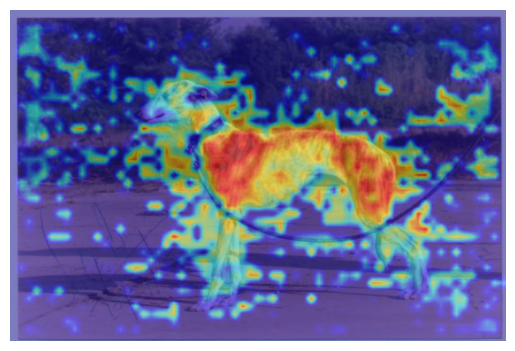

In [8]:
w, h = img.size
print(w,h)
resize = Resize((h,w))

c_ret = visualize(emap, img.copy(), resize)
plt.imshow(c_ret)
plt.axis('off')
plt.show()